In [11]:
# 开启多行显示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last_expr"

# 显示图片
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 数据探索
XGBoost中数据形式可以是libsvm的，libsvm作用是对稀疏特征进行优化，看个例子：

```
1 101:1.2 102:0.03 
0 1:2.1 10001:300 10002:400
0 2:1.2 1212:21 7777:2
```
每行表示一个样本，每行开头0，1表示标签，而后面的则是特征索引：数值，其他未表示都是0.

我们以判断蘑菇是否有毒为例子来做后续的训练。数据集来自：http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/ ，其中蘑菇有22个属性，将这些原始的特征加工后得到126维特征，并保存为libsvm格式，标签是表示蘑菇是否有毒。其中其中 6513 个样本做训练，1611 个样本做测试。

In [1]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

> DMatrix is a internal data structure that used by XGBoost
which is optimized for both memory efficiency and training speed.

DMatrix 的数据来源可以是 `string/numpy array/scipy.sparse/pd.DataFrame`，如果是 string，则代表 libsvm 文件的路径，或者是 xgboost 可读取的二进制文件路径。

In [2]:
data_fold = "./data/"
dtrain = xgb.DMatrix(data_fold + "agaricus.txt.train")
dtest = xgb.DMatrix(data_fold + "agaricus.txt.test")

查看数据情况

In [12]:
(dtrain.num_col(),dtrain.num_row())
(dtest.num_col(),dtest.num_row())

(127, 6513)

(127, 1611)

## 模型训练
基本参数设定：
- max_depth： 树的最大深度。缺省值为6，取值范围为：[1,∞] 
- eta：为了防止过拟合，更新过程中用到的收缩步长。eta通过缩减特征 的权重使提升计算过程更加保守。缺省值为0.3，取值范围为：[0,1] 
- silent: 0表示打印出运行时信息，取1时表示以缄默方式运行，不打印 运行时信息。缺省值为0 
- objective： 定义学习任务及相应的学习目标，“binary:logistic” 表示 二分类的逻辑回归问题，输出为概率。

In [14]:
param = {'max_depth':2, 'eta':1, 'silent':0, 'objective':'binary:logistic' }

In [15]:
%time
# 设置boosting迭代计算次数
num_round = 2

bst = xgb.train(param, dtrain, num_round)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 65.6 µs


此处模型输出是一个概率值，我们将其转换为0-1值，然后再计算准确率

In [16]:
train_preds = bst.predict(dtrain)
train_predictions = [round(value) for value in train_preds]
y_train = dtrain.get_label()
train_accuracy = accuracy_score(y_train, train_predictions)
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))

Train Accuary: 97.77%


我们最后再测试集上看下模型的准确率的

In [17]:
preds = bst.predict(dtest)
predictions = [round(value) for value in preds]
y_test = dtest.get_label()
test_accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 97.83%


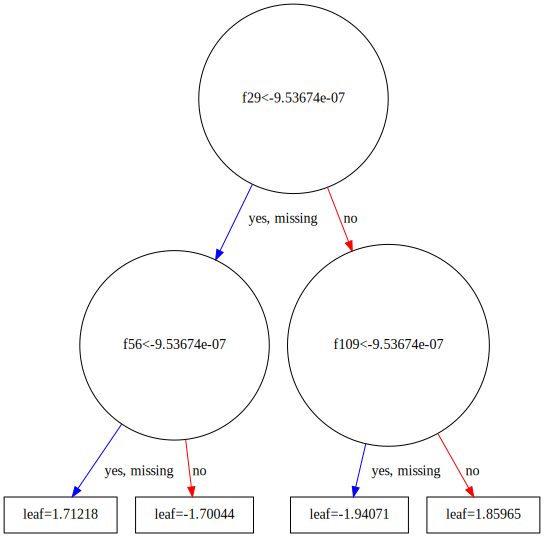

In [23]:
from matplotlib import pyplot
import graphviz
xgb.to_graphviz(bst, num_trees=0 )
pyplot.show()

## scikit-learn 接口格式

In [29]:
from xgboost import XGBClassifier
from sklearn.datasets import load_svmlight_file

In [30]:
my_workpath = './data/'
X_train,y_train = load_svmlight_file(my_workpath + 'agaricus.txt.train')
X_test,y_test = load_svmlight_file(my_workpath + 'agaricus.txt.test')

# 设置boosting迭代计算次数
num_round = 2

#bst = XGBClassifier(**params)
#bst = XGBClassifier()
bst =XGBClassifier(max_depth=2, learning_rate=1, n_estimators=num_round, 
                   silent=True, objective='binary:logistic')

bst.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=2,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
# 训练集上准确率
train_preds = bst.predict(X_train)
train_predictions = [round(value) for value in train_preds]

train_accuracy = accuracy_score(y_train, train_predictions)
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))

Train Accuary: 97.77%


In [32]:
# 测试集上准确率
# make prediction
preds = bst.predict(X_test)
predictions = [round(value) for value in preds]

test_accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 97.83%


## scikit-lean 中 cv 使用
做cross_validation主要用到下面 StratifiedKFold 函数

In [33]:
# 设置boosting迭代计算次数
num_round = 2
bst =XGBClassifier(max_depth=2, learning_rate=0.1,n_estimators=num_round, 
                   silent=True, objective='binary:logistic')

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [35]:
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(bst, X_train, y_train, cv=kfold)
print(results)
print("CV Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[ 0.69478528  0.85276074  0.95398773  0.97235023  0.96006144  0.98771121
  1.          1.          0.96927803  0.97695853]
CV Accuracy: 93.68% (9.00%)


## GridSearchcv 搜索最优解

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
bst =XGBClassifier(max_depth=2, learning_rate=0.1, silent=True, objective='binary:logistic')

In [41]:
%time
param_grid = {
 'n_estimators': range(1, 51, 1)
}
clf = GridSearchCV(bst, param_grid, "accuracy",cv=5)
clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 24.3 µs


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(1, 51)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [45]:
clf.best_params_, clf.best_score_

({'n_estimators': 30}, 0.98418547520343924)

In [46]:
## 在测试集合上测试
#make prediction
preds = clf.predict(X_test)
predictions = [round(value) for value in preds]

test_accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy of gridsearchcv: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy of gridsearchcv: 97.27%


## early-stop
我们设置验证valid集，当我们迭代过程中发现在验证集上错误率增加，则提前停止迭代。

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
seed = 7
test_size = 0.33
X_train_part, X_validate, y_train_part, y_validate= train_test_split(X_train, y_train, test_size=test_size,
    random_state=seed)

X_train_part.shape
X_validate.shape

(4363, 126)

(2150, 126)

In [51]:
# 设置boosting迭代计算次数
num_round = 100


bst =XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=num_round, silent=True, objective='binary:logistic')

eval_set =[(X_validate, y_validate)]
bst.fit(X_train_part, y_train_part, early_stopping_rounds=10, eval_metric="error",
    eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.048372
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.042326
[2]	validation_0-error:0.048372
[3]	validation_0-error:0.042326
[4]	validation_0-error:0.042326
[5]	validation_0-error:0.042326
[6]	validation_0-error:0.023256
[7]	validation_0-error:0.042326
[8]	validation_0-error:0.042326
[9]	validation_0-error:0.023256
[10]	validation_0-error:0.006512
[11]	validation_0-error:0.017674
[12]	validation_0-error:0.017674
[13]	validation_0-error:0.017674
[14]	validation_0-error:0.017674
[15]	validation_0-error:0.017674
[16]	validation_0-error:0.017674
[17]	validation_0-error:0.017674
[18]	validation_0-error:0.024651
[19]	validation_0-error:0.020465
[20]	validation_0-error:0.020465
Stopping. Best iteration:
[10]	validation_0-error:0.006512



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

我们可以将上面的错误率进行可视化，方便我们更直观的观察

Text(0,0.5,'Error')

Text(0.5,0,'Round')

Text(0.5,1,'XGBoost Early Stop')

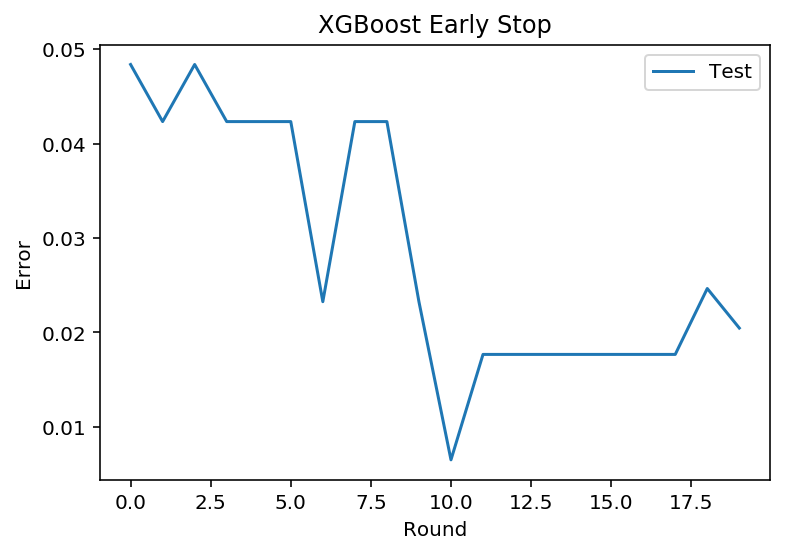

In [53]:
results = bst.evals_result()
#print(results)

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Test')
ax.legend()
pyplot.ylabel('Error')
pyplot.xlabel('Round')
pyplot.title('XGBoost Early Stop')
pyplot.show()

In [54]:
# 测试集上准确率
# make prediction
preds = bst.predict(X_test)
predictions = [round(value) for value in preds]

test_accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 97.27%


## 学习曲线

In [55]:
# 设置boosting迭代计算次数
num_round = 100

# 没有 eraly_stop
bst =XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=num_round, silent=True, objective='binary:logistic')

eval_set = [(X_train_part, y_train_part), (X_validate, y_validate)]
bst.fit(X_train_part, y_train_part, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.045611	validation_0-logloss:0.614637	validation_1-error:0.048372	validation_1-logloss:0.615401
[1]	validation_0-error:0.041256	validation_0-logloss:0.549907	validation_1-error:0.042326	validation_1-logloss:0.550696
[2]	validation_0-error:0.045611	validation_0-logloss:0.49543	validation_1-error:0.048372	validation_1-logloss:0.496777
[3]	validation_0-error:0.041256	validation_0-logloss:0.449089	validation_1-error:0.042326	validation_1-logloss:0.450412
[4]	validation_0-error:0.041256	validation_0-logloss:0.409231	validation_1-error:0.042326	validation_1-logloss:0.410717
[5]	validation_0-error:0.041256	validation_0-logloss:0.373748	validation_1-error:0.042326	validation_1-logloss:0.375653
[6]	validation_0-error:0.023378	validation_0-logloss:0.343051	validation_1-error:0.023256	validation_1-logloss:0.344738
[7]	validation_0-error:0.041256	validation_0-logloss:0.315369	validation_1-error:0.042326	validation_1-logloss:0.317409
[8]	validation_0-error:0.041256	validatio

[68]	validation_0-error:0.001834	validation_0-logloss:0.028064	validation_1-error:0.002326	validation_1-logloss:0.028391
[69]	validation_0-error:0.001834	validation_0-logloss:0.027404	validation_1-error:0.002326	validation_1-logloss:0.027725
[70]	validation_0-error:0.001834	validation_0-logloss:0.026824	validation_1-error:0.002326	validation_1-logloss:0.027187
[71]	validation_0-error:0.001834	validation_0-logloss:0.026268	validation_1-error:0.002326	validation_1-logloss:0.026565
[72]	validation_0-error:0.001834	validation_0-logloss:0.025679	validation_1-error:0.002326	validation_1-logloss:0.025982
[73]	validation_0-error:0.001834	validation_0-logloss:0.025153	validation_1-error:0.002326	validation_1-logloss:0.025413
[74]	validation_0-error:0.001834	validation_0-logloss:0.02461	validation_1-error:0.002326	validation_1-logloss:0.024927
[75]	validation_0-error:0.001834	validation_0-logloss:0.0241	validation_1-error:0.002326	validation_1-logloss:0.02446
[76]	validation_0-error:0.001834	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Text(0,0.5,'Log Loss')

Text(0.5,1,'XGBoost Log Loss')

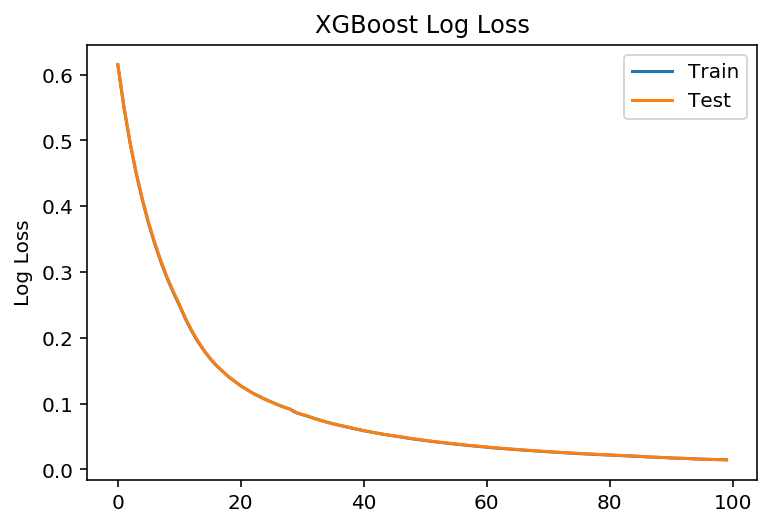

Text(0,0.5,'Classification Error')

Text(0.5,1,'XGBoost Classification Error')

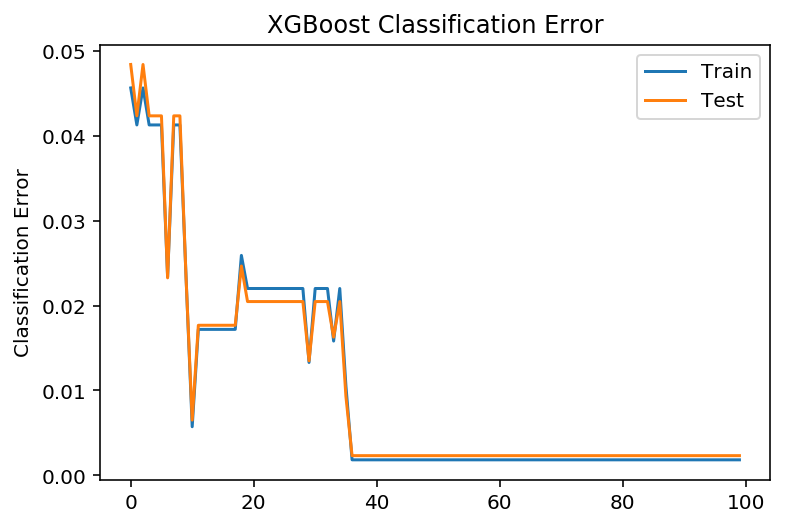

In [56]:
# retrieve performance metrics
results = bst.evals_result()
#print(results)


epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [57]:
# make prediction
preds = bst.predict(X_test)
predictions = [round(value) for value in preds]

test_accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 99.81%
